# Построение ML-продукта для оптимизации классификации заявок на оплату для сервиса Repetit.ru

**Описание проекта**
<br>Сервис Repetit.ru работает с большим количеством заявок от клиентов с данными о предмете,
<br>желаемой стоимости, возрасте ученика, целью занятий и тд.
<br>К сожалению, 7 из 8 не доходят до оплаты, при этом обработка заявки консультантом увеличивает конверсию в оплату на 30%.
<br>Проблема в том, что консультантов не хватает на все заявки и получается, что чем больше заявок —
<br>тем меньше конверсия из заявки в оплату и консультанты тратят время на бесперспективные заявки.

**Цель:**
- Сократить загрузку отдела консультантов на 30%
- Увеличить конверсию в оплату на 15 п.п. через сегментацию заявок по вероятности их оплаты

**Задачи:**
<br>Разработать модель, которая по имеющейся информации о клиенте и заявке будет предсказывать вероятность оплаты заявки клиентом.
<br>Заказчик хочет понять, какие заявки будут оплачены, а какие нет, чтобы одни обрабатывать вручную консультантами, а другие нет.
<br>Оценка качества модели будет производиться с использованием `precision` и `ROC-AUC`.

**Целевые метрики (пожелания от заказчика)**
- 50-75% от общего объёма заявок можно будет не обрабатывать, так как они не будут оплачены
- обозначение топ 5-25% заявок, которым нужно отдать максимальный приоритет
- допускается, что модель будет показывать больше заявок как хороших, чем на самом деле (ошибка precision оплаченных заявок)
- не допускается, что модель относит потенциально оплаченные заявки к плохим заявкам (низкая precision неоплаченных заявок)

Данные для 0 (неоплачено) и 1 (оплачено) классов.
<br>`recall`, например, для оплаченных заявок показывает процент предсказанных как оплаченные от всех истинно оплаченных заявок. <br>`f1-score` это некий баланс между `precision` и `recall`.
<br>А `support` - кол-во наблюдений отнесенных к тому или иному классу.

|class|precision|recall|f1-score|support|
|--:|--:|--:|--:|--:|
|0|0.89|1.00|0.94|187629|
|1|0.50|0.02|0.04|24097|

**Ход исследования:**
- загрузка данных и ознакомление с ними,
- отбор подходящих признаков,
- EDA,
- создание новых признаков (при необходимости),
- отбор финального набора обучающих признаков,
- выбор и обучение моделей (разных архитектур),
- оценка качества предсказания лучшей модели на тестовой выборке,
- анализ важности признаков лучшей модели,
- создание сервиса в виде Docker Container,
- отчёт по проведённому исследованию.

**Описание данных**
- Заявки (orders*.csv)
  - order_date - дата создания
  - subject_id - предмет
  - purpose - цель занятий
  - lesson_price - цена
  - lesson_duration - желаемая проодолжительность урока
  - home_metro_id - ближайшее метро
  - add_info - доп инфо
  - start_date
  - working_teacher_id
  - status_id - оплачена ли заявка (значения 6 и 13 говорят о факте оплаты заявки)
  - comments   
  - amount_to_pay
  - planned_lesson_number - клиент планирует N занятий
  - first_lesson_date - дата 1 занятия
  - coef - коэффициент
  - creator_id - кто создал заявку (id сотрудника или клиента)
  - pupil_category_new_id - возраст ученика
  - lessons_per_week - занятий а неделю
  - minimal_price
  - teacher_sex - пол репетитора
  - teacher_experience_from - опыт репетитора от
  - teacher_experience_to- опыт репетитора до
  - lesson_place_new - онлайн, у ученика, у учителя
  - pupil_knowledgelvl -уровень знаний ученика
  - teacher_age_from - желаемый возраст репеитора от
  - teacher_age_to - желаемый возраст репеитора от
  - chosen_teachers_only - не предлагать репетиторов кроме выбранных самостоятельно
  - no_teachers_available - на заявку нет подходящих репов
  - source_id - где создана заявка (какая часть сайта, не регион)
  - original_order_id - дублем какой заявки является эта заявка
  - client_id - айди клиента
  - additional_status_id
  - max_metro_distance - максимально готов ехать от метро
  - estimated_fee
  - payment_date
  - test_group - аб тесты
  - is_display_to_teachers - хочет ли клиент получать отклики репетиторов

- Репетиторы (teacher_info.csv)
  - date_update
  - reg_date
  - birth_date
  - teaching_start_date
  - user_id - айди
  - is_email_confirmed
  - is_home_lessons
  - is_external_lessons
  - external_comments
  - lesson_duration - продолжит урока
  - lesson_cost - стоимость урока
  - status_id
  - status_relevant_date
  - status_school_id
  - status_college_id
  - status_display
  - russian_level_id
  - home_country_id
  - education
  - information
  - is_confirmed
  - is_display - показывается в каталоге
  - rating_id
  - rating - рейтинг
  - comments
  - rules_confirmed_date
  - last_visited - послеждний визит
  - is_pupils_needed - открыт для заявок
  - is_cell_phone_confirmed
  - effective_rating - какой-то еще рейтинг
  - area_id
  - registrar_id
  - pupil_needed_date
  - sex
  - amount_to_pay - долг
  - is_remote_lessons
  - remote_comments
  - show_on_map
  - send_mailing
  - send_suitable_orders
  - rating_for_users - рейтинг 2
  - rating_for_admin - рейтинг 3
  - passport_id
  - is_edited
  - orders_allowed - разрешено назначать на заявки
  - display_days
  - verification_status_id
  - is_individual
  - partner_id
  - star_rating - рейтинг 4
  - rating_for_users_yesterday - рейтинг вчера
  - review_num - отзывы
  - relevance_date
  - is_display_at_partners
  - video_presentation_id - есть видеопрезентация
  - status_institution_id
  - Free_time_relevance_date


- Подходящие по фильтру репетиторы (suitable_teachers.csv)
  - tteacher_id - id репетитора
  - order_id - id заявки
  - contact_result    
  - enable_auto_assign - доступен ли репетитор к работе или заблокирован
    <br>(может ли репетитора назначить консультант и может ли он сам назначиться)
    <br>(значение известно на момент подачи заявки)
  - enable_assign - доступен ли репетитор к работе или заблокирован
    <br>(может ли репетитора назначить консультант и может ли он сам назначиться)
    <br>(значение известно на момент подачи заявки)


- Желаемые репетиторы (prefered_teachers_order_id.csv)
  <br>Репетиторы, которых выбрал клиент.
  - tteacher_id - id репетитора
  - order_id - id заявки

## Настройка рабочей среды

In [1]:
# import shap
# import phik
# import torch
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
# import lightgbm as lgb
import matplotlib.pyplot as plt

# from catboost import CatBoostClassifier, Pool
# from phik.report import plot_correlation_matrix
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OrdinalEncoder, StandardScaler
# from sklearn.metrics import roc_curve, roc_auc_score, precision_score

warnings.filterwarnings("ignore", category=UserWarning)

Монтирование диска (Google Colab)

In [2]:
from google.colab import userdata
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Подключение к GPU

In [4]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Установка констант

In [3]:
RANDOM_STATE = 42

Установка `random_state`

In [4]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

## Загрузка данных

In [5]:
try:
  orders = pd.read_feather('data/orders.feather')
  teachers_info = pd.read_feather('data/teachers_info.feather')
  suitable_teachers = pd.read_feather('data/suitable_teachers.feather')
  prefered_teachers_order_id = pd.read_feather('data/prefered_teachers_order_id.feather')
  print('загружено из каталога "data"')
except:
  orders = pd.read_feather(userdata.get('orders_path'))
  teachers_info = pd.read_feather(userdata.get('teachers_info'))
  suitable_teachers = pd.read_feather(userdata.get('suitable_teachers'))
  prefered_teachers_order_id = pd.read_feather(userdata.get('preferred_teachers_order_id'))
  print('загружено из каталога Google Drive')

загружено из каталога Google Drive


### Заявки

In [6]:
orders.info()
orders.sample()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,...,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
40101,1881671,2021-12-06 17:01:13.553,13.0,Разделы: школьный курс.\nДополнения: ЕГЭ.\nКа...,500,60,None,2276.0,Район: г. Каспийск.\nМесто проведения занятий:...,None,...,0,1,16,NaN,878030,8.0,NaN,None,None,1


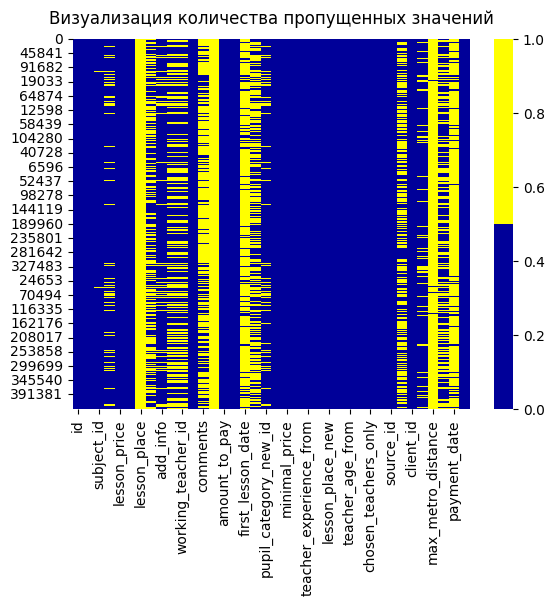

In [7]:
sns.heatmap(orders.isnull(), cmap=sns.color_palette(['#000099', '#ffff00']))
plt.xticks(rotation=90)
plt.title('Визуализация количества пропущенных значений', size=12, y=1.02)
plt.show()

In [8]:
print(f"количество полных дубликатов строк: {orders.duplicated().sum()}")
print(f"количество полных дубликатов в общем количестве строк: {orders.duplicated().sum() / orders.shape[0] * 100:.3f}%")

количество полных дубликатов строк: 900
количество полных дубликатов в общем количестве строк: 0.076%


Удаление обнаруженных повторов строк

In [9]:
orders = orders.drop_duplicates().reset_index(drop=True)

In [10]:
print(f"уникальные значения status_id:\n{orders['status_id'].value_counts().sort_index(ascending=False)}")

уникальные значения status_id:
3605505         1
3342337         1
3211265         1
16         791756
15           3469
14          32933
13           2111
12           4731
11           7202
9            1057
8            8178
7          212694
6          121413
5             291
4            1852
3            3166
2               3
1             102
Name: status_id, dtype: int64


Удаление строк с некорректным значением status_id

In [11]:
orders = orders.drop(orders[orders['status_id'] > 16].index)

Создание целевого признака

In [12]:
orders['fact_of_payment'] = orders['status_id'].apply(lambda x: 1 if x == 6 or x == 13 else 0).astype('int8')

Изменение типов данных

In [13]:
orders[['order_date', 'start_date', 'first_lesson_date', 'payment_date']] = (
    orders[['order_date', 'start_date', 'first_lesson_date', 'payment_date']].apply(pd.to_datetime)
    )

In [18]:
print(f"уникальные значения subject_id:\n{orders['subject_id'].value_counts().sort_index(ascending=False)}")

уникальные значения subject_id:
36.0      5625
33.0     33318
29.0     12622
27.0     12281
25.0      4909
23.0      7281
21.0     24767
20.0     16651
19.0     46684
18.0     64282
17.0      7853
16.0      8171
15.0     11367
14.0     36796
13.0     20048
12.0     42127
11.0     59734
10.0     57223
9.0      58706
8.0     311066
7.0      16147
6.0       8682
5.0       4456
4.0      12595
3.0      17515
2.0     170675
1.0     109052
0.0      10325
Name: subject_id, dtype: int64


Удаление строк с некорректным значением subject_id

In [15]:
orders = orders.drop(orders[orders['subject_id'] > 36].index)

Заполнение пропусков в subject_id

In [17]:
'''
пропущенные значения означают, что поле с предметом не заполнено.
на мой взгляд, их логично заполнить нулями.
'''
orders['subject_id'] = orders['subject_id'].fillna(0)

In [32]:
# print(f"уникальные значения subject_id:\n{orders['purpose'].value_counts()}")
orders['purpose'].unique()[2987]

'Разделы:  школьный курс.\nКатегория ученика: школьник 7 класса. Математическая вертикаль.\nЦель занятий: восполнить пробелы, подготовка к поступлению в лицей при МГТУ им. Н.Э. Баумана.'

purpose (цель занятий)
<br>Разделы: ораторское искусство.
<br>Дополнения: ЕГЭ.
<br>Категория ученика: студент 2 курса.
<br>Уровень знаний: средний.
<br>Цель занятий: для себя.
<br>ОЧНЫЕ ЗАНЯТИЯ.

In [19]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1190958 entries, 0 to 1190959
Data columns (total 39 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   id                       1190958 non-null  int32         
 1   order_date               1190958 non-null  datetime64[ns]
 2   subject_id               1190958 non-null  float32       
 3   purpose                  1024538 non-null  object        
 4   lesson_price             1190958 non-null  int32         
 5   lesson_duration          1190958 non-null  int32         
 6   lesson_place             31 non-null       object        
 7   home_metro_id            642006 non-null   float32       
 8   add_info                 1043862 non-null  object        
 9   start_date               705098 non-null   datetime64[ns]
 10  working_teacher_id       705508 non-null   float32       
 11  status_id                1190958 non-null  int32         
 12  

In [118]:
print(f"текущая размерность таблицы: {orders.shape}")
print(f"текущее количество уникальных номеров заявок: {orders['id'].nunique()}")

текущая размерность таблицы: (1191847, 38)
текущее количество уникальных номеров заявок: 1190948


In [98]:
order_ids = orders[orders['original_order_id'].notna()]['original_order_id'].unique().astype('int32')

In [99]:
orders[(orders['id'].isin(order_ids)) | (orders['original_order_id'].isin(order_ids))]

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,...,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,None,...,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,None,...,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,...,0,0,23,NaN,1024439,10.0,NaN,1200,None,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,...,0,0,14,2293804.0,1024340,17.0,NaN,2310,None,1
5,2294059,2022-11-01 00:20:30.610,3.0,None,0,60,None,464.0,None,None,...,0,0,16,NaN,1024441,5.0,NaN,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437208,2280499,2022-10-24 19:43:29.907,1.0,None,0,60,None,NaN,None,None,...,0,0,16,2280388.0,1019587,7.0,NaN,None,None,1
437209,2280500,2022-10-24 19:44:06.077,8.0,Разделы: школьный курс.\nДополнения: ЕГЭ.\nКа...,1100,90,None,1034.0,Район: Московский район.\nМесто проведения зан...,None,...,0,1,14,2243958.0,1006956,8.0,NaN,3135,None,1
437213,2280504,2022-10-24 19:45:40.713,1.0,Разделы: школьный курс.\nКатегория ученика: ш...,1000,120,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-10-24 20:07:25.370,...,0,0,14,2280289.0,362987,13.0,NaN,2700,None,1
437215,2280506,2022-10-24 19:46:02.453,18.0,Разделы: математика.\nКатегория ученика: школь...,900,60,None,487.0,Район: Автозаводский район.\nМесто проведения ...,None,...,0,1,14,2200131.0,791697,8.0,NaN,2565,None,1


,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,...,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers


In [70]:
df[(df['col1'] > 2) | (df['col2'] < 40)]

   id_x  original_order_id_x  id_y  original_order_id_y
0     2                    4     1                    2
1     4                    8     2                    4


In [33]:
# orders_processed[orders_processed['id'].isin(orders_processed['original_order_id'])].sample(3)
# orders_processed['original_order_id'].nunique()
# orders_processed[orders_processed['id'] | orders_processed['original_order_id']]

In [75]:
orders_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   id                 5 non-null      int64
 1   original_order_id  5 non-null      int64
dtypes: int64(2)
memory usage: 208.0 bytes


Создание копии датафрейма без лишних признаков

In [74]:
orders_processed = orders.copy()
orders_processed = orders_processed.drop(['prefered_teacher_id',
                                          'lesson_place',
                                          'status_id'],
                                         axis=1)

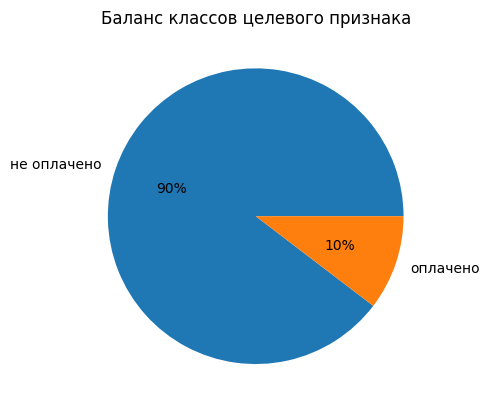

In [18]:
labels = 'не оплачено', 'оплачено'
sizes = [orders['fact_of_payment'].value_counts()[0],
         orders['fact_of_payment'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.0f%%')
plt.title('Баланс классов целевого признака', size=12)
plt.show()

#### Выводы и наблюдения
- в таблице обнаружены дубликаты строк (0.076% от общего количества данных)
- принято решение об удалении найденных повторов ввиду их малочисленности
- удалены три строки с некорректными значениями признака `status_id`
- создан целевой признак `fact_of_payment`
- даты преобразованы в корректный формат
- удалены четыре строки с некорректными значениями признака `subject_id`
- пропуски в признаке `subject_id` (10325 штук) заполнены нулями
- дубликатов в номерах заявок нет
-
-
- создана копия датафрейма без признаков, не представлющих ценности для исследования
- наблюдается значительный дисбаланс классов целевого признака

### Репетиторы

In [ ]:
teachers_info.info()
teachers_info.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          307972 non-null  int32   
 1   date_update                 307972 non-null  category
 2   reg_date                    307972 non-null  category
 3   birth_date                  307972 non-null  category
 4   teaching_start_date         307972 non-null  category
 5   user_id                     307972 non-null  int32   
 6   is_email_confirmed          307972 non-null  int8    
 7   is_home_lessons             307972 non-null  int8    
 8   is_external_lessons         307972 non-null  int8    
 9   external_comments           90978 non-null   category
 10  lesson_duration             307972 non-null  int16   
 11  lesson_cost                 307972 non-null  int32   
 12  status_id                   307972 non-null  int8    
 13 

,id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,...,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
178850,183252,2023-01-19 16:36:40.530,2019-10-19 23:25:32.710,1997-03-15 00:00:00.000,2017-09-01 00:00:00.000,575554,0,0,0,NaN,...,0,NaN,NaN,4.300781,25.0,0,2019-10-19 23:25:32.710,0,NaN,NaN
106999,109468,2023-01-19 19:34:48.507,2016-09-11 10:05:35.000,1979-07-25 00:00:00.000,2004-09-01 00:00:00.000,178310,1,1,0,NaN,...,0,0.0,NaN,4.300781,0.0,0,2017-05-26 11:40:03.000,1,NaN,NaN
276483,281108,2023-01-19 18:25:02.947,2022-12-09 14:06:13.150,2004-10-04 00:00:00.000,2019-09-01 00:00:00.000,1088271,0,0,0,NaN,...,0,NaN,NaN,4.300781,0.0,0,2022-12-09 14:06:13.150,1,NaN,NaN


In [ ]:
print(f"количество полных дубликатов строк: {teachers_info.duplicated().sum()}")

количество полных дубликатов строк: 0


#### Выводы и наблюдения
- в таблице полных дубликатов строк не обнаружено

### Подходящие по фильтру репетиторы

In [ ]:
suitable_teachers.info()
suitable_teachers.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271186 entries, 0 to 20271185
Data columns (total 5 columns):
 #   Column              Dtype   
---  ------              -----   
 0   teacher_id          int32   
 1   order_id            int32   
 2   contact_result      category
 3   enable_auto_assign  int8    
 4   enable_assign       int8    
dtypes: category(1), int32(2), int8(2)
memory usage: 232.3 MB


,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
6112763,51367,2370961,н,0,0
19654525,920,2928278,NaN,0,0
16295120,88743,2817561,NaN,0,0


In [ ]:
print(f"количество полных дубликатов строк: {suitable_teachers.duplicated().sum()}")
print(f"""количество полных дубликатов в общем количестве строк: {suitable_teachers.duplicated().sum() /
suitable_teachers.shape[0] * 100:.4f}%""")

количество полных дубликатов строк: 49
количество полных дубликатов в общем количестве строк: 0.0002%


Удаление обнаруженных повторов

In [ ]:
suitable_teachers = suitable_teachers.drop_duplicates().reset_index(drop=True)

In [ ]:
print(f"уникальные записи колонки contact_result: {suitable_teachers['contact_result'].unique()}")
print(f"количество уникальных записей колонки contact_result: {suitable_teachers['contact_result'].nunique()}")

уникальные записи колонки contact_result: ['Репетитор согласился', 'Репетитор положил трубку, либо обрыв связи (O..., ',', NaN, 'Не дозвонились (Oktell)', ..., 'Богородский', '23 екат', 'Репетитор согласился с дополнительными услови..., 'Репетитор согласился с дополнительными услови..., 'к ученику?']
Length: 10867
Categories (10866, object): ['\nРепетитор оставил запрос : ', '\nРепетитор оставил запрос : \nРепетитор оста...,
                             '\nРепетитор оставил запрос : Договорились о з..., '\nРепетитор оставил запрос : О занятии догово...,
                             ..., '№',
                             '№1 анкета понравилась, кл пока не хочет конта..., '№2 анкета не понравилась',
                             '№3 анкета отправлена,  кл еще не смотрела']
количество уникальных записей колонки contact_result: 10866


In [ ]:
print(f"уникальные записи колонки enable_auto_assign: {suitable_teachers['enable_auto_assign'].unique()}")
print(f"уникальные записи колонки enable_assign: {suitable_teachers['enable_assign'].unique()}")

уникальные записи колонки enable_auto_assign: [1 0]
уникальные записи колонки enable_assign: [1 0]


#### Выводы и наблюдения
- в таблице обнаружены дубликаты строк (0.0002% от общего количества данных)
- принято решение об удалении найденных повторов ввиду их малочисленности
- к категориальным признакам относятся: enable_auto_assign и enable_assign
- в признаке contact_result внесена информация в произвольном формате,
  <br>имеются совсем неинформативные записи ('23 екат', '...')

### Желаемые репетиторы (которых выбрал клиент)

In [ ]:
prefered_teachers_order_id.info()
prefered_teachers_order_id.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135198 entries, 0 to 1135197
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype
---  ------      --------------    -----
 0   order_id    1135198 non-null  int32
 1   teacher_id  1135198 non-null  int32
dtypes: int32(2)
memory usage: 8.7 MB


,order_id,teacher_id
10497,1914739,4247
695435,2720606,127721
686625,2207750,156109


In [ ]:
print(f"количество полных дубликатов строк: {prefered_teachers_order_id.duplicated().sum()}")
print(f"количество полных дубликатов в общем количестве строк: {prefered_teachers_order_id.duplicated().sum() / prefered_teachers_order_id.shape[0] * 100:.3f}%")

количество полных дубликатов строк: 16
количество полных дубликатов в общем количестве строк: 0.001%


Удаление обнаруженных повторов

In [ ]:
prefered_teachers_order_id = prefered_teachers_order_id.drop_duplicates().reset_index(drop=True)

#### Выводы и наблюдения
- в таблице обнаружены дубликаты строк (0.001% от общего количества данных)
- принято решение об удалении найденных повторов ввиду их малочисленности

## Выбор лучшей модели

In [ ]:
dict_sum = {'Baseline': [roc_auc_baseline, precision_baseline],
         'Catboost': [roc_auc_cb, precision_cb],
         'LightGBM': [roc_auc_lgb, precision_lgb]}
summary_data = (pd.DataFrame.from_dict(dict_sum, orient='index',
                                      columns=["roc-auc", "precision"]).reset_index()
                                      .rename(columns={'index': 'model'})
                                      )
summary_data

## Создание файла зависимостей

In [ ]:
# !pipreqsnb operator_performance_analytics.ipynb

## Заключение